# Day 5: CatBoost for Trading

## 🎯 Learning Objectives
- Understand CatBoost innovations
- Handle categorical features natively
- Apply ordered boosting
- Compare with XGBoost and LightGBM

---

## 📚 Theory: CatBoost

### What Makes CatBoost Different

| Feature | CatBoost Innovation |
|---------|--------------------|
| Categorical | Target encoding with ordered statistics |
| Boosting | Ordered boosting (reduces overfitting) |
| Trees | Symmetric (oblivious) trees |
| GPU | Excellent GPU support |

### Ordered Target Statistics
Traditional target encoding leaks information. CatBoost uses:
$$\hat{x}_k = \frac{\sum_{j<i} [x_j = x_i] \cdot y_j + a \cdot p}{\sum_{j<i} [x_j = x_i] + a}$$

Where:
- Only uses samples **before** current sample
- $a$: smoothing parameter
- $p$: prior (target mean)

### Ordered Boosting
- Standard boosting: Use all data for residuals
- Ordered boosting: Use random permutation, predict with trees built on preceding samples
- Reduces prediction shift (target leakage)

### Symmetric Trees
- Same feature and threshold at each level
- Faster inference
- Natural regularization

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

# CatBoost doesn't support Python 3.14 yet, so we'll use sklearn's 
# HistGradientBoostingClassifier which has native categorical support
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")
print("\n⚠️ Note: Using sklearn's HistGradientBoostingClassifier instead of CatBoost")
print("   (CatBoost doesn't support Python 3.14 yet)")

📥 Downloading data...
✅ Data: 1256 days

⚠️ Note: Using sklearn's HistGradientBoostingClassifier instead of CatBoost
   (CatBoost doesn't support Python 3.14 yet)


In [2]:
# Create features with categorical variables
df = pd.DataFrame(index=prices.index)

# Flatten Series if needed (yfinance sometimes returns multi-level columns)
prices_flat = prices.squeeze() if hasattr(prices, 'squeeze') else prices
volume_flat = volume.squeeze() if hasattr(volume, 'squeeze') else volume
returns_flat = returns.squeeze() if hasattr(returns, 'squeeze') else returns

df['price'] = prices_flat
df['return'] = returns_flat

# Numerical features
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices_flat.pct_change(lag)

for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns_flat.rolling(window).std()

df['volume_ratio'] = volume_flat / volume_flat.rolling(20).mean()
df['ma_5_20'] = prices_flat.rolling(5).mean() / prices_flat.rolling(20).mean() - 1

# RSI
delta = prices_flat.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Categorical features
df['day_of_week'] = df.index.dayofweek.astype(str)  # Keep as string
df['month'] = df.index.month.astype(str)

# Volatility regime (categorical)
vol_20 = returns_flat.rolling(20).std()
vol_quantiles = pd.qcut(vol_20.dropna(), q=3, labels=['low', 'medium', 'high'])
df['vol_regime'] = vol_quantiles.astype(str)

# Target
df['next_return'] = returns_flat.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Samples: {len(df)}")

📊 Samples: 1235


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
categorical_cols = ['day_of_week', 'month', 'vol_regime']
numerical_cols = [c for c in feature_cols if c not in categorical_cols]

X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# Get categorical indices for CatBoost
cat_indices = [X.columns.get_loc(c) for c in categorical_cols]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Categorical columns: {categorical_cols}")
print(f"Categorical indices: {cat_indices}")

Train: 988, Test: 247
Categorical columns: ['day_of_week', 'month', 'vol_regime']
Categorical indices: [10, 11, 12]


In [4]:
# HistGradientBoostingClassifier with native categorical handling
# This is sklearn's implementation similar to CatBoost/LightGBM

# Prepare data with categorical features properly marked
X_train_hist = X_train.copy()
X_test_hist = X_test.copy()

# Convert categorical columns to proper dtype for HistGradientBoosting
for col in categorical_cols:
    X_train_hist[col] = X_train_hist[col].astype('category')
    X_test_hist[col] = X_test_hist[col].astype('category')

hist_gb = HistGradientBoostingClassifier(
    max_iter=200,
    max_depth=5,
    learning_rate=0.1,
    categorical_features=categorical_cols,
    random_state=42
)

start = time.time()
hist_gb.fit(X_train_hist, y_train)
hist_time = time.time() - start

print("\n" + "="*60)
print("HISTGRADIENTBOOSTING TRAINING (sklearn - CatBoost alternative)")
print("="*60)
print(f"Training time: {hist_time:.2f} seconds")
print(f"Number of iterations: {hist_gb.n_iter_}")


HISTGRADIENTBOOSTING TRAINING (sklearn - CatBoost alternative)
Training time: 3.42 seconds
Number of iterations: 200


In [5]:
# Compare all three boosting methods
# For fair comparison, encode categoricals for XGBoost/LightGBM
X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

X_train_enc = X_encoded.iloc[:split_idx]
X_test_enc = X_encoded.iloc[split_idx:]

# XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                   random_state=42, eval_metric='logloss')
start = time.time()
xgb.fit(X_train_enc, y_train)
xgb_time = time.time() - start

# LightGBM
lgbm = lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                          random_state=42, verbosity=-1)
start = time.time()
lgbm.fit(X_train_enc, y_train)
lgbm_time = time.time() - start

print("\n" + "="*70)
print("BOOSTING METHOD COMPARISON")
print("="*70)

results = []
for name, model, test_data, train_time in [
    ('XGBoost', xgb, X_test_enc, xgb_time),
    ('LightGBM', lgbm, X_test_enc, lgbm_time),
    ('HistGradientBoosting', hist_gb, X_test_hist, hist_time)
]:
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    
    results.append({
        'Model': name,
        'Train Time': f'{train_time:.2f}s',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("\n📝 Note: HistGradientBoosting is sklearn's CatBoost-like implementation")


BOOSTING METHOD COMPARISON
               Model Train Time  Accuracy       F1      AUC
             XGBoost      0.63s  0.481781 0.511450 0.524357
            LightGBM      0.37s  0.542510 0.600707 0.553440
HistGradientBoosting      3.42s  0.510121 0.569395 0.540901

📝 Note: HistGradientBoosting is sklearn's CatBoost-like implementation


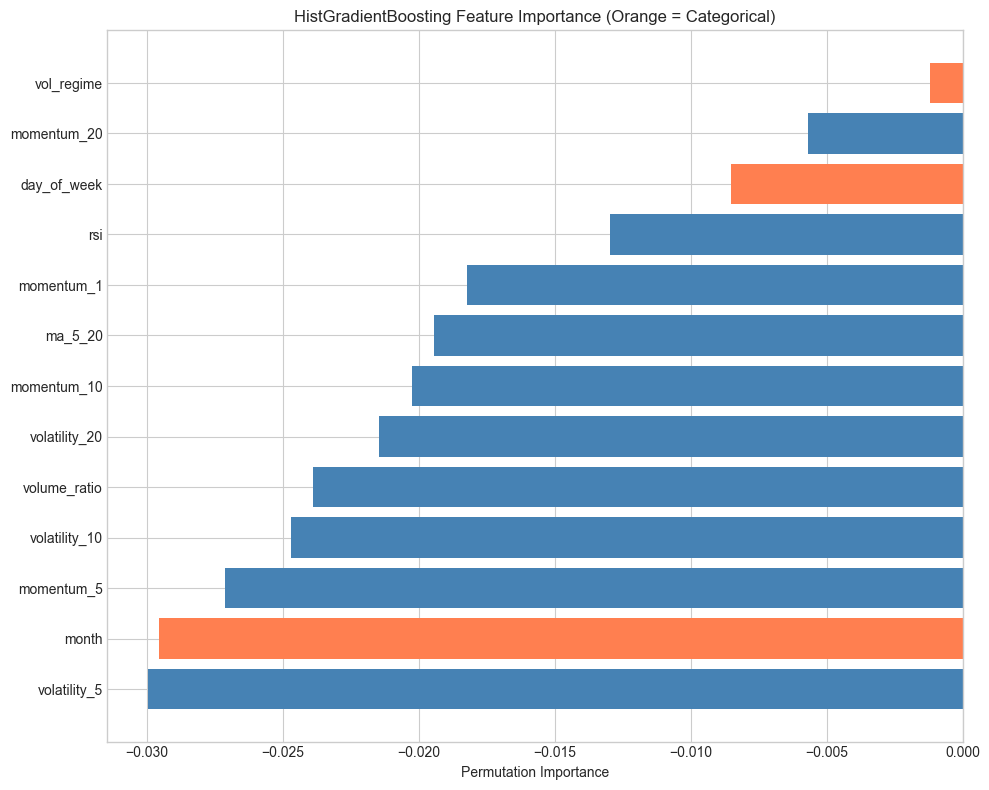

In [6]:
# Feature Importance from HistGradientBoosting
# Note: HistGradientBoosting uses permutation importance by default
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(hist_gb, X_test_hist, y_test, n_repeats=10, random_state=42)

importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
colors = ['coral' if f in categorical_cols else 'steelblue' for f in importance['Feature']]
plt.barh(importance['Feature'], importance['Importance'], color=colors)
plt.xlabel('Permutation Importance')
plt.title('HistGradientBoosting Feature Importance (Orange = Categorical)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

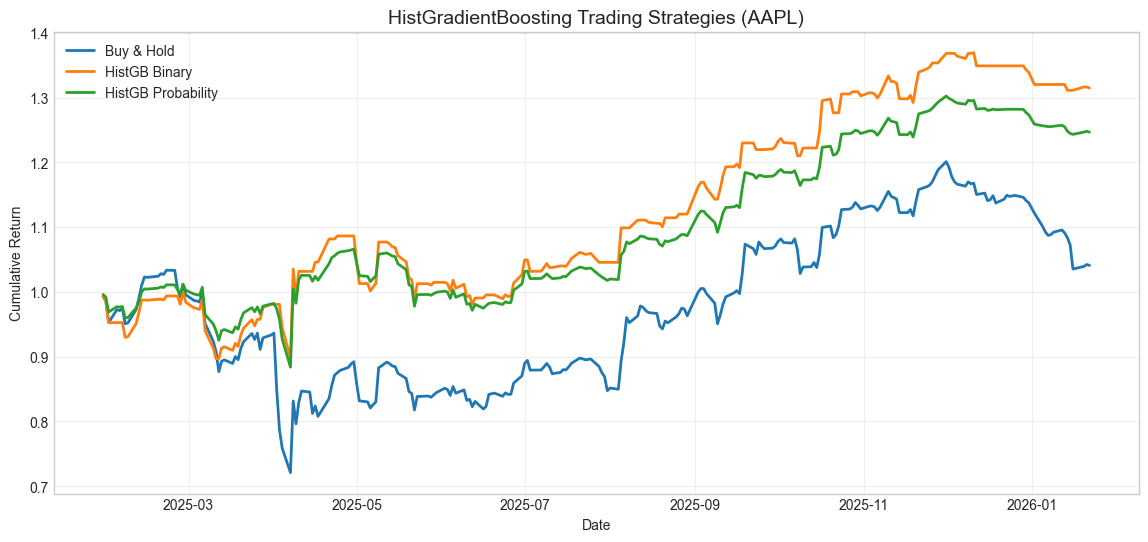

In [7]:
# Trading Strategy Backtest
y_pred = hist_gb.predict(X_test_hist)
y_proba = hist_gb.predict_proba(X_test_hist)[:, 1]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Strategies
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()

backtest['prob_signal'] = y_proba
backtest['prob_return'] = backtest['prob_signal'] * backtest['actual_return']
backtest['prob_cum'] = (1 + backtest['prob_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='HistGB Binary', linewidth=2)
plt.plot(backtest.index, backtest['prob_cum'], label='HistGB Probability', linewidth=2)
plt.title(f'HistGradientBoosting Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('HistGB Binary', 'strategy_return', 'strategy_cum'),
    ('HistGB Probability', 'prob_return', 'prob_cum')
]

print(f"\n{'Strategy':<25} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 60)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<25} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                     Total Ret     Sharpe     Max DD
------------------------------------------------------------
Buy & Hold                       4.10%       0.13    -30.22%
HistGB Binary                   31.46%       1.01    -10.28%
HistGB Probability              24.66%       0.92    -12.64%


In [9]:
# Next day prediction
latest = X_test_hist.iloc[-1:].copy()
pred = hist_gb.predict(latest)[0]
proba = hist_gb.predict_proba(latest)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nCategorical Context:")
for col in categorical_cols:
    print(f"  {col}: {latest[col].values[0]}")
print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Probability (Down/Up): [{proba[0]:.2%}, {proba[1]:.2%}]")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-22

Categorical Context:
  day_of_week: 3
  month: 1
  vol_regime: low

Prediction: 📈 UP
Probability (Down/Up): [17.01%, 82.99%]


---

## 🏢 Real-World Applications

| Company | CatBoost Use Case |
|---------|------------------|
| Yandex | Web search ranking |
| CloudFlare | Security classification |
| Finance | Many categorical features |
| Retail | Customer segmentation |

### Key Interview Points
1. **Why CatBoost for categoricals?** - Ordered target statistics prevent leakage
2. **Ordered boosting?** - Reduces overfitting by using different data for residuals
3. **Symmetric trees?** - Same split at each level, faster inference
4. **When to use?** - Many categorical features, robust out-of-box performance

### Note on Python 3.14
⚠️ CatBoost doesn't yet support Python 3.14. In this notebook, we used sklearn's `HistGradientBoostingClassifier` which provides similar native categorical feature support. When CatBoost adds Python 3.14 support, you can switch back to the original implementation.

---
## 📅 Tomorrow: Ensemble Stacking